<a href="https://colab.research.google.com/github/Liza23/Seasons-of-Code_Why-Hype-Around-GAN-s/blob/master/GAN%7CKeras%7CCIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Packages

In [0]:
#The necessory packages are installed first. 

In [2]:
from __future__ import print_function, division
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


Import CIFAR-10 Dataset

In [0]:
#The CIFAR-10 Dataset is loaded on the colab notebook. 

In [0]:
from keras.datasets.cifar10 import load_data

In [11]:
(trainX, trainy), (testX, testy) = load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [12]:
print('Train shape', trainX.shape)

Train shape (50000, 32, 32, 3)


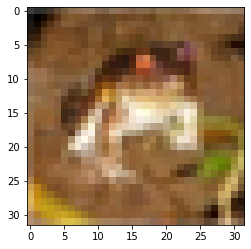

In [13]:
#First training image is plotted
plt.imshow(trainX[0])

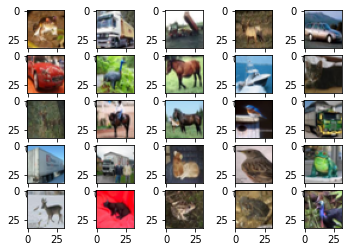

In [14]:
#The first 25 images from the train dataset are plotted
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.imshow(trainX[i])
plt.show()

In [0]:
#Normalize image data set to bring values from -1 to 1.
#Normalizing inputs around mean and variance allows
#faster learning due to the symmtery of inputs. 
X_train = trainX.astype('float32')
# scale from [0,255] to [-1,1]
X_train = (X_train - 127.5) / 127.5

In [16]:
print(X_train.shape)

(50000, 32, 32, 3)


In [0]:
#We'll split the training data into mini-batches to
#peform mini-batch gradient decent. 
batch_size=1000
batch_count=int(X_train.shape[0]/batch_size)
half_batch = int(batch_size / 2)

In [0]:
#Latent_dimensions are used to feed input in generator
#these are used as dimension for creating noise.
latent_dimension=100

In [19]:
print("batch_size : ",batch_size)
print("batch_count : ",batch_count)
print("half_batch : ", half_batch)
print("latent_dimension : ",latent_dimension)

batch_size :  1000
batch_count :  50
half_batch :  500
latent_dimension :  100


In [20]:
#here we try to flatten the input dimensions as it is
#a 3D vector and we need a 1D input for a discriminator. 
X_train=np.reshape(X_train,(-1,32*32*3))
print(X_train.shape)

(50000, 3072)


Generator Function

In [0]:
#Before defining the model, we define the optimizer used 
#as the Adam optimizer as it is known to show better results.
optimizer = Adam(learning_rate = 0.001)

In [0]:
def create_generator():
  inputs=  Input(shape=(latent_dimension,))

  #here as an input we use the latent_dimension which 
  #correspond to the dimensions of the noise we'll use
  x=Dense(units=32*32*3)(inputs)
  x=Reshape((32,32,3))(x)

  x=Conv2D(64, (3,3))(x)
  x=LeakyReLU(0.2)(x)

  x=Conv2D(64, (3,3))(x)
  x=LeakyReLU(0.2)(x)

  x=Flatten()(x)
  #whenever we use a dense layer it is necessary to 
  #flatten the inputs before. 
  x=Dense(units=256)(x)
  x=LeakyReLU(0.2)(x)

  # x=Dense(units=512)(x)
  # x=LeakyReLU(0.2)(x)

  x=Dense(units=1024)(x)
  x=LeakyReLU(0.2)(x)

  #the output layer here should have same dimensions as the real image 
  #dimensions as we'll then feed the output by gan into the discriminator.
  x=Dense(units=3072, activation='tanh')(x) 
  outputs=Reshape((32,32,3), name='out_layer')(x)
      
  generator=Model(inputs=inputs, outputs=outputs)
  generator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return generator
  
  #model.add(BatchNormalization(momentum=0.8))

In [23]:
#this gives the summary of the generator model used and includes 
#the layers, thier outputs and parameters used. 
g=create_generator()
g.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3072)              310272    
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 64)        0   

Dicriminator Function

In [0]:
def create_discriminator():
  inputs=  Input(shape=(X_train.shape[1],))

  x=Dense(units=1024)(inputs)
  x=LeakyReLU(0.2)(x)
  x=Dropout(0.3)(x)

  x=Dense(units=512)(x)
  x=LeakyReLU(0.2)(x)
  x=Dropout(0.3) (x)

  x=Dense(units=256)(x)
  x=LeakyReLU(0.2)(x)

  outputs=Dense(units=1, activation='sigmoid')(x)

  discriminator=Model(inputs=inputs, outputs=outputs)
  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return discriminator

In [25]:
d = create_discriminator()
d.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0   

Defining GAN

In [0]:
def create_gan(discriminator, generator):

    gan_input = Input(shape=(latent_dimension,))

    x = generator(gan_input)
    x= Flatten()(x)
    
    discriminator.trainable=False

    gan_output= discriminator(x)

    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')

    return gan

In [27]:
gan=create_gan(d,g)
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         16606272  
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
model_2 (Model)              (None, 1)                 3803137   
Total params: 20,409,409
Trainable params: 16,606,272
Non-trainable params: 3,803,137
_________________________________________________________________


Generate images from Generator Function

In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])

    generated_images = generator.predict(noise)
    #generated_images = generated_images.reshape(100,32,32)

    #plt.figure(figsize=figsize)

    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')

    #plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

Training Model

In [0]:
epochs=50
num_batches=int(half_batch)

In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow w

Epoch 0 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.138573]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 0 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.629440]
Epoch 0 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.652161]
Epoch 0 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.559479]
Epoch 0 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.068741]
Epoch 0 Batch 5/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 65.969261]
Epoch 0 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.605156]
Epoch 0 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.214806]
Epoch 0 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.797447]
Epoch 0 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.961258]
Epoch 0 Batch 10/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 65.445572]
Epoch 0 Batch 11/500 [D loss: 0.000004, acc.: 100.00%] [G loss: 65.701591]
Epoch 0 Batch 12/500 [D loss: 0.000016, acc.: 100.00%] [G loss: 65.870689]
Epoch 0 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.693344]
Epoch 0 Batch 14/500 [D loss: 0.00

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Cli

Epoch 0 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.766907]
Epoch 1 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.288399]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 1 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.238594]
Epoch 1 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.190987]
Epoch 1 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.138031]
Epoch 1 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.109810]
Epoch 1 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.202179]
Epoch 1 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.934914]
Epoch 1 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.563644]
Epoch 1 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.324585]
Epoch 1 Batch 9/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 65.587013]
Epoch 1 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.025169]
Epoch 1 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.587387]
Epoch 1 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.312370]
Epoch 1 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.480034]
Epoch 1 Batch 14/500 [D loss: 0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 1 Batch 49/500 [D loss: 0.000003, acc.: 100.00%] [G loss: 65.179451]
Epoch 2 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.859970]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 2 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.917854]
Epoch 2 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.730843]
Epoch 2 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.554771]
Epoch 2 Batch 4/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 65.623589]
Epoch 2 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.288048]
Epoch 2 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.689194]
Epoch 2 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.204201]
Epoch 2 Batch 8/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 65.308197]
Epoch 2 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.533722]
Epoch 2 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.555069]
Epoch 2 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.322998]
Epoch 2 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.588989]
Epoch 2 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.214096]
Epoch 2 Batch 14/500 [D loss: 0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 2 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.961525]
Epoch 3 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.506523]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 3 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.928513]
Epoch 3 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.591133]
Epoch 3 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.093674]
Epoch 3 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.181099]
Epoch 3 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.515968]
Epoch 3 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.722725]
Epoch 3 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.963211]
Epoch 3 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.210159]
Epoch 3 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.960785]
Epoch 3 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.547195]
Epoch 3 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.186363]
Epoch 3 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.120522]
Epoch 3 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.912064]
Epoch 3 Batch 14/500 [D loss: 0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 3 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.552834]
Epoch 4 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.261955]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 4 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.673561]
Epoch 4 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.843826]
Epoch 4 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.737495]
Epoch 4 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.362503]
Epoch 4 Batch 5/500 [D loss: 0.000006, acc.: 100.00%] [G loss: 65.243683]
Epoch 4 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.008453]
Epoch 4 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.565498]
Epoch 4 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.244705]
Epoch 4 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.699455]
Epoch 4 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.322433]
Epoch 4 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.910553]
Epoch 4 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.277100]
Epoch 4 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.771553]
Epoch 4 Batch 14/500 [D loss: 0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 4 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.113335]
Epoch 5 Batch 0/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 64.027817]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 5 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.444618]
Epoch 5 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.303558]
Epoch 5 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.818657]
Epoch 5 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.696724]
Epoch 5 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.091011]
Epoch 5 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.097298]
Epoch 5 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.626953]
Epoch 5 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.941765]
Epoch 5 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.196495]
Epoch 5 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.723839]
Epoch 5 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.563568]
Epoch 5 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.675751]
Epoch 5 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.187553]
Epoch 5 Batch 14/500 [D loss: 0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 5 Batch 49/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 64.194405]
Epoch 6 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.280838]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 6 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.368034]
Epoch 6 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.556419]
Epoch 6 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.503525]
Epoch 6 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.736259]
Epoch 6 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.562401]
Epoch 6 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.679810]
Epoch 6 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.386337]
Epoch 6 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.952576]
Epoch 6 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.891479]
Epoch 6 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.331253]
Epoch 6 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.434494]
Epoch 6 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.450798]
Epoch 6 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.731224]
Epoch 6 Batch 14/500 [D loss: 0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 6 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.885017]
Epoch 7 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.724976]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 7 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.451241]
Epoch 7 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.638500]
Epoch 7 Batch 3/500 [D loss: 0.000002, acc.: 100.00%] [G loss: 63.555164]
Epoch 7 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.439087]
Epoch 7 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.852119]
Epoch 7 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.995724]
Epoch 7 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.335716]
Epoch 7 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.022392]
Epoch 7 Batch 9/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 64.091248]
Epoch 7 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.452560]
Epoch 7 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.750435]
Epoch 7 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.026787]
Epoch 7 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.313683]
Epoch 7 Batch 14/500 [D loss: 0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 7 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.908836]
Epoch 8 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.369919]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 8 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.772564]
Epoch 8 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.804176]
Epoch 8 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.050865]
Epoch 8 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.265221]
Epoch 8 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.623638]
Epoch 8 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.389069]
Epoch 8 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.313110]
Epoch 8 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.134094]
Epoch 8 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.424927]
Epoch 8 Batch 10/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 63.864594]
Epoch 8 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.716225]
Epoch 8 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.853523]
Epoch 8 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.473068]
Epoch 8 Batch 14/500 [D loss: 0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 8 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.349167]
Epoch 9 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.135757]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 9 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.214157]
Epoch 9 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.110001]
Epoch 9 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.356522]
Epoch 9 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.792755]
Epoch 9 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.360435]
Epoch 9 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.655468]
Epoch 9 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.357368]
Epoch 9 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.132996]
Epoch 9 Batch 9/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 63.149406]
Epoch 9 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.393093]
Epoch 9 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.701035]
Epoch 9 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.002815]
Epoch 9 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.968769]
Epoch 9 Batch 14/500 [D loss: 0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 9 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.491356]
Epoch 10 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.837826]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 10 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.886650]
Epoch 10 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.167068]
Epoch 10 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.950466]
Epoch 10 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.394241]
Epoch 10 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.653099]
Epoch 10 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.408440]
Epoch 10 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.394600]
Epoch 10 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.649952]
Epoch 10 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.929413]
Epoch 10 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.516705]
Epoch 10 Batch 11/500 [D loss: 0.000008, acc.: 100.00%] [G loss: 63.758408]
Epoch 10 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.818562]
Epoch 10 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.216034]
Epoch 10 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 10 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.730289]
Epoch 11 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.374710]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 11 Batch 1/500 [D loss: 0.000004, acc.: 100.00%] [G loss: 62.783501]
Epoch 11 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.942150]
Epoch 11 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.423328]
Epoch 11 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.307102]
Epoch 11 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.825218]
Epoch 11 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.722424]
Epoch 11 Batch 7/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 62.660023]
Epoch 11 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.826054]
Epoch 11 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.226704]
Epoch 11 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.569450]
Epoch 11 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.618824]
Epoch 11 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.219505]
Epoch 11 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.771118]
Epoch 11 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 11 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.239727]
Epoch 12 Batch 0/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 61.723526]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 12 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.492256]
Epoch 12 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.882782]
Epoch 12 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.365372]
Epoch 12 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.934521]
Epoch 12 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.188774]
Epoch 12 Batch 6/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 62.114445]
Epoch 12 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.269218]
Epoch 12 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.479893]
Epoch 12 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.927090]
Epoch 12 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.850876]
Epoch 12 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.786572]
Epoch 12 Batch 12/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 62.242645]
Epoch 12 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.807976]
Epoch 12 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 12 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.359211]
Epoch 13 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.497009]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 13 Batch 1/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 62.227432]
Epoch 13 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.408760]
Epoch 13 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.234985]
Epoch 13 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 61.807365]
Epoch 13 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.365261]
Epoch 13 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 61.777611]
Epoch 13 Batch 7/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 62.930210]
Epoch 13 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.734158]
Epoch 13 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.620270]
Epoch 13 Batch 10/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 63.249771]
Epoch 13 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.970955]
Epoch 13 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.896580]
Epoch 13 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.075390]
Epoch 13 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 13 Batch 49/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 63.423325]
Epoch 14 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.022713]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 14 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.501205]
Epoch 14 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.835411]
Epoch 14 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.327766]
Epoch 14 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.880180]
Epoch 14 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.189522]
Epoch 14 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.676254]
Epoch 14 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.268677]
Epoch 14 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.366638]
Epoch 14 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.163620]
Epoch 14 Batch 10/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 68.014023]
Epoch 14 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.338936]
Epoch 14 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.563095]
Epoch 14 Batch 13/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 67.136986]
Epoch 14 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 14 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.519829]
Epoch 15 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.271217]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 15 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.681404]
Epoch 15 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.730537]
Epoch 15 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.578529]
Epoch 15 Batch 4/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 68.249825]
Epoch 15 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.234428]
Epoch 15 Batch 6/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 68.631813]
Epoch 15 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.082878]
Epoch 15 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.153641]
Epoch 15 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.605255]
Epoch 15 Batch 10/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 68.143188]
Epoch 15 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.611084]
Epoch 15 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.000191]
Epoch 15 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.776657]
Epoch 15 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 15 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.420975]
Epoch 16 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.685410]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 16 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.922913]
Epoch 16 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.023102]
Epoch 16 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.446075]
Epoch 16 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.706627]
Epoch 16 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.866028]
Epoch 16 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.226379]
Epoch 16 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.501083]
Epoch 16 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.713127]
Epoch 16 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.935204]
Epoch 16 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.659531]
Epoch 16 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.041702]
Epoch 16 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.402649]
Epoch 16 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.246201]
Epoch 16 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 16 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.751015]
Epoch 17 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.775597]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 17 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.794830]
Epoch 17 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.960022]
Epoch 17 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.025101]
Epoch 17 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.165688]
Epoch 17 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.210312]
Epoch 17 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.584389]
Epoch 17 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.698235]
Epoch 17 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.980675]
Epoch 17 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.531784]
Epoch 17 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.806808]
Epoch 17 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.401772]
Epoch 17 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.397232]
Epoch 17 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.984871]
Epoch 17 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 17 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.132439]
Epoch 18 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.041924]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 18 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.465233]
Epoch 18 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.739220]
Epoch 18 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.558189]
Epoch 18 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.830666]
Epoch 18 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.751457]
Epoch 18 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.321411]
Epoch 18 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.418221]
Epoch 18 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.443405]
Epoch 18 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.129608]
Epoch 18 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.056313]
Epoch 18 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.843803]
Epoch 18 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.118378]
Epoch 18 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.577652]
Epoch 18 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 18 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.187393]
Epoch 19 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.009338]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 19 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.738747]
Epoch 19 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.499886]
Epoch 19 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.431145]
Epoch 19 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.986076]
Epoch 19 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.061676]
Epoch 19 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.684860]
Epoch 19 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.895454]
Epoch 19 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.126961]
Epoch 19 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.758095]
Epoch 19 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.579102]
Epoch 19 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.390770]
Epoch 19 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.532913]
Epoch 19 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.638733]
Epoch 19 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 19 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.702782]
Epoch 20 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.689140]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 20 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.303474]
Epoch 20 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 68.096527]
Epoch 20 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.406128]
Epoch 20 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.975662]
Epoch 20 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.847878]
Epoch 20 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.391220]
Epoch 20 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.493919]
Epoch 20 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.474533]
Epoch 20 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.126610]
Epoch 20 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.620018]
Epoch 20 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.730736]
Epoch 20 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.196182]
Epoch 20 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 67.737503]
Epoch 20 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 20 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.536659]
Epoch 21 Batch 0/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 66.888420]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 21 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.160500]
Epoch 21 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.196091]
Epoch 21 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.673111]
Epoch 21 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.868011]
Epoch 21 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.819992]
Epoch 21 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.685822]
Epoch 21 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.620094]
Epoch 21 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.231697]
Epoch 21 Batch 9/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 66.695679]
Epoch 21 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.988205]
Epoch 21 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.162796]
Epoch 21 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.242569]
Epoch 21 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.737709]
Epoch 21 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 21 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.164032]
Epoch 22 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.263634]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 22 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.399963]
Epoch 22 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.690842]
Epoch 22 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.175438]
Epoch 22 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.724609]
Epoch 22 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.374634]
Epoch 22 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.688591]
Epoch 22 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.887527]
Epoch 22 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.875603]
Epoch 22 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.262642]
Epoch 22 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.263596]
Epoch 22 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.103264]
Epoch 22 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.626396]
Epoch 22 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.294220]
Epoch 22 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 22 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.884323]
Epoch 23 Batch 0/500 [D loss: 0.000003, acc.: 100.00%] [G loss: 65.802612]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 23 Batch 1/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 66.225220]
Epoch 23 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.457100]
Epoch 23 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.582344]
Epoch 23 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.061340]
Epoch 23 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.892761]
Epoch 23 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.368660]
Epoch 23 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.438560]
Epoch 23 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.857941]
Epoch 23 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.373093]
Epoch 23 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.207268]
Epoch 23 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.360344]
Epoch 23 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.476936]
Epoch 23 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.138206]
Epoch 23 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 23 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.433159]
Epoch 24 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.658669]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 24 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.816452]
Epoch 24 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.965370]
Epoch 24 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.393700]
Epoch 24 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.442833]
Epoch 24 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.901215]
Epoch 24 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.529823]
Epoch 24 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.264771]
Epoch 24 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.373680]
Epoch 24 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.543465]
Epoch 24 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.929970]
Epoch 24 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.569748]
Epoch 24 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.200989]
Epoch 24 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.804512]
Epoch 24 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 24 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.726654]
Epoch 25 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.184013]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 25 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.582016]
Epoch 25 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.185005]
Epoch 25 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.504868]
Epoch 25 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.950294]
Epoch 25 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.211716]
Epoch 25 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.972900]
Epoch 25 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.139656]
Epoch 25 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.980072]
Epoch 25 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.200264]
Epoch 25 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.986595]
Epoch 25 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.294365]
Epoch 25 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.974373]
Epoch 25 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.525513]
Epoch 25 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 25 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.683502]
Epoch 26 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.474861]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 26 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.897141]
Epoch 26 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.374786]
Epoch 26 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.543991]
Epoch 26 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.290909]
Epoch 26 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.944130]
Epoch 26 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.345985]
Epoch 26 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.453140]
Epoch 26 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.264679]
Epoch 26 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.692413]
Epoch 26 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.235687]
Epoch 26 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.172287]
Epoch 26 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.522934]
Epoch 26 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.465500]
Epoch 26 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 26 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.148018]
Epoch 27 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.631737]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 27 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.386650]
Epoch 27 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.354935]
Epoch 27 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.959946]
Epoch 27 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.614441]
Epoch 27 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.516754]
Epoch 27 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.545731]
Epoch 27 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.498116]
Epoch 27 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.412018]
Epoch 27 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.614929]
Epoch 27 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.615677]
Epoch 27 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.253784]
Epoch 27 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.605988]
Epoch 27 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.835838]
Epoch 27 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 27 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.477638]
Epoch 28 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.142479]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 28 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.350815]
Epoch 28 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.015533]
Epoch 28 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.646263]
Epoch 28 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.255531]
Epoch 28 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.246979]
Epoch 28 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.957855]
Epoch 28 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.870331]
Epoch 28 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.006157]
Epoch 28 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.798584]
Epoch 28 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.391121]
Epoch 28 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.185272]
Epoch 28 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.639046]
Epoch 28 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.607216]
Epoch 28 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 28 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.875893]
Epoch 29 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.092339]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 29 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.511589]
Epoch 29 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.160233]
Epoch 29 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.209930]
Epoch 29 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.656303]
Epoch 29 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.401489]
Epoch 29 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.130104]
Epoch 29 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.386292]
Epoch 29 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.147316]
Epoch 29 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.476799]
Epoch 29 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.311455]
Epoch 29 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.147202]
Epoch 29 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.706329]
Epoch 29 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.620766]
Epoch 29 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 29 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.384750]
Epoch 30 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.426178]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 30 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.474327]
Epoch 30 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.754730]
Epoch 30 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.256889]
Epoch 30 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.795570]
Epoch 30 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.018791]
Epoch 30 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.068939]
Epoch 30 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.074623]
Epoch 30 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.643333]
Epoch 30 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.578415]
Epoch 30 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.136200]
Epoch 30 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.396515]
Epoch 30 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.659508]
Epoch 30 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.873779]
Epoch 30 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 30 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.187523]
Epoch 31 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.786934]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 31 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.313126]
Epoch 31 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.377075]
Epoch 31 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.346123]
Epoch 31 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.702927]
Epoch 31 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.013474]
Epoch 31 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.693817]
Epoch 31 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.870140]
Epoch 31 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.602119]
Epoch 31 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.950485]
Epoch 31 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.416458]
Epoch 31 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.588867]
Epoch 31 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.320435]
Epoch 31 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 66.257385]
Epoch 31 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 31 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.520798]
Epoch 32 Batch 0/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 64.122223]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 32 Batch 1/500 [D loss: 0.000005, acc.: 100.00%] [G loss: 64.460266]
Epoch 32 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.500137]
Epoch 32 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.425880]
Epoch 32 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.063110]
Epoch 32 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.657692]
Epoch 32 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.735733]
Epoch 32 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.652214]
Epoch 32 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.537354]
Epoch 32 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.210670]
Epoch 32 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.214043]
Epoch 32 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.216141]
Epoch 32 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.392754]
Epoch 32 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.385330]
Epoch 32 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 32 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.291428]
Epoch 33 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.096550]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 33 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.400833]
Epoch 33 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.103691]
Epoch 33 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.085732]
Epoch 33 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.869003]
Epoch 33 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.090202]
Epoch 33 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.649666]
Epoch 33 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.196945]
Epoch 33 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.099335]
Epoch 33 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.216103]
Epoch 33 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.794685]
Epoch 33 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.807102]
Epoch 33 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.093773]
Epoch 33 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 65.152069]
Epoch 33 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 33 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.355019]
Epoch 34 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.723793]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 34 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.672211]
Epoch 34 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.605286]
Epoch 34 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.032204]
Epoch 34 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.661362]
Epoch 34 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.670166]
Epoch 34 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.894104]
Epoch 34 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.593567]
Epoch 34 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.615807]
Epoch 34 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.801819]
Epoch 34 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.067841]
Epoch 34 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.600479]
Epoch 34 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.669434]
Epoch 34 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.342125]
Epoch 34 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 34 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.793255]
Epoch 35 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.044716]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 35 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.080185]
Epoch 35 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.471077]
Epoch 35 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.141747]
Epoch 35 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.620983]
Epoch 35 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.397675]
Epoch 35 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.458855]
Epoch 35 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.335068]
Epoch 35 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.839870]
Epoch 35 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.372864]
Epoch 35 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.954891]
Epoch 35 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.310516]
Epoch 35 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.032402]
Epoch 35 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.588005]
Epoch 35 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 35 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.621735]
Epoch 36 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.683830]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 36 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.953259]
Epoch 36 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.019005]
Epoch 36 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.219177]
Epoch 36 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.827988]
Epoch 36 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.585716]
Epoch 36 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.926929]
Epoch 36 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.440369]
Epoch 36 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.308365]
Epoch 36 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.532120]
Epoch 36 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.920242]
Epoch 36 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.959999]
Epoch 36 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.540703]
Epoch 36 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.859283]
Epoch 36 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 36 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.826023]
Epoch 37 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.076630]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 37 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.917103]
Epoch 37 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.303387]
Epoch 37 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.123352]
Epoch 37 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.163498]
Epoch 37 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.801270]
Epoch 37 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.959255]
Epoch 37 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.709538]
Epoch 37 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.210373]
Epoch 37 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.922825]
Epoch 37 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.502239]
Epoch 37 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.853992]
Epoch 37 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.744129]
Epoch 37 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.572861]
Epoch 37 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 37 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.140617]
Epoch 38 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.311371]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 38 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.936413]
Epoch 38 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.117661]
Epoch 38 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.821705]
Epoch 38 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.017929]
Epoch 38 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.172356]
Epoch 38 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.678593]
Epoch 38 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.446751]
Epoch 38 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.788700]
Epoch 38 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.555607]
Epoch 38 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.773476]
Epoch 38 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.104462]
Epoch 38 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.931652]
Epoch 38 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.891438]
Epoch 38 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 38 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.587894]
Epoch 39 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.109497]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 39 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.081612]
Epoch 39 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.247269]
Epoch 39 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.803257]
Epoch 39 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.021000]
Epoch 39 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.987850]
Epoch 39 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.347939]
Epoch 39 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.603485]
Epoch 39 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.323013]
Epoch 39 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.531021]
Epoch 39 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.257210]
Epoch 39 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.679199]
Epoch 39 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.222095]
Epoch 39 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.826477]
Epoch 39 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 39 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.920574]
Epoch 40 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.323429]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 40 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.257927]
Epoch 40 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.007343]
Epoch 40 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.072014]
Epoch 40 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.275162]
Epoch 40 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.601799]
Epoch 40 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.995605]
Epoch 40 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.106789]
Epoch 40 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.079281]
Epoch 40 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.232113]
Epoch 40 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.102646]
Epoch 40 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.588501]
Epoch 40 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.966900]
Epoch 40 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.085403]
Epoch 40 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 40 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.317795]
Epoch 41 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.140739]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 41 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.331196]
Epoch 41 Batch 2/500 [D loss: 0.000001, acc.: 100.00%] [G loss: 63.674126]
Epoch 41 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.923069]
Epoch 41 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.528248]
Epoch 41 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.333519]
Epoch 41 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.155365]
Epoch 41 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.034336]
Epoch 41 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.314804]
Epoch 41 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.767895]
Epoch 41 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.470078]
Epoch 41 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.438446]
Epoch 41 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.471634]
Epoch 41 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.004169]
Epoch 41 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 41 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.574142]
Epoch 42 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.277573]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 42 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.154114]
Epoch 42 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.957325]
Epoch 42 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.678463]
Epoch 42 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.954113]
Epoch 42 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.404224]
Epoch 42 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.075130]
Epoch 42 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.453735]
Epoch 42 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.924183]
Epoch 42 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.062374]
Epoch 42 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.819370]
Epoch 42 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.987476]
Epoch 42 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.968246]
Epoch 42 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.136372]
Epoch 42 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 42 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.624081]
Epoch 43 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.965340]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 43 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.632881]
Epoch 43 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.690578]
Epoch 43 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.954502]
Epoch 43 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.353905]
Epoch 43 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.205502]
Epoch 43 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.855885]
Epoch 43 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.671761]
Epoch 43 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.995754]
Epoch 43 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.459969]
Epoch 43 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.204445]
Epoch 43 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.555035]
Epoch 43 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.525917]
Epoch 43 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.709885]
Epoch 43 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 43 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.061073]
Epoch 44 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.189911]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 44 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.880119]
Epoch 44 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.627430]
Epoch 44 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.534992]
Epoch 44 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.502640]
Epoch 44 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.847195]
Epoch 44 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.932014]
Epoch 44 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.874462]
Epoch 44 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.317650]
Epoch 44 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.568539]
Epoch 44 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.871891]
Epoch 44 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.948200]
Epoch 44 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.275158]
Epoch 44 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.548576]
Epoch 44 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 44 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.480263]
Epoch 45 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.457981]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 45 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.774223]
Epoch 45 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.703705]
Epoch 45 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.965302]
Epoch 45 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.069298]
Epoch 45 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.973484]
Epoch 45 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.537247]
Epoch 45 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.241993]
Epoch 45 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.401970]
Epoch 45 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.428787]
Epoch 45 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.173584]
Epoch 45 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.571583]
Epoch 45 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.527515]
Epoch 45 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.481869]
Epoch 45 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 45 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.957920]
Epoch 46 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.531288]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 46 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.056931]
Epoch 46 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.117805]
Epoch 46 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.392326]
Epoch 46 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.445679]
Epoch 46 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.434258]
Epoch 46 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.120468]
Epoch 46 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.667477]
Epoch 46 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.639503]
Epoch 46 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.710812]
Epoch 46 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.920612]
Epoch 46 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.059265]
Epoch 46 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 64.072342]
Epoch 46 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.682320]
Epoch 46 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 46 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.640724]
Epoch 47 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.158234]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 47 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.170681]
Epoch 47 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.240574]
Epoch 47 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.955822]
Epoch 47 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.237762]
Epoch 47 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.903767]
Epoch 47 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.176567]
Epoch 47 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.791363]
Epoch 47 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.473965]
Epoch 47 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.396370]
Epoch 47 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 62.884190]
Epoch 47 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.116230]
Epoch 47 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.065182]
Epoch 47 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 63.811974]
Epoch 47 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 47 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.101776]
Epoch 48 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.727615]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 48 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.576759]
Epoch 48 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.756798]
Epoch 48 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.746445]
Epoch 48 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.242180]
Epoch 48 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 89.237503]
Epoch 48 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.736366]
Epoch 48 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 89.155418]
Epoch 48 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.331299]
Epoch 48 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.761528]
Epoch 48 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.303856]
Epoch 48 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.743492]
Epoch 48 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.329643]
Epoch 48 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.432449]
Epoch 48 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 48 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.630203]
Epoch 49 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.996544]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 49 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.469963]
Epoch 49 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.968246]
Epoch 49 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.246811]
Epoch 49 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.000969]
Epoch 49 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.933182]
Epoch 49 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.313423]
Epoch 49 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.057526]
Epoch 49 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.514740]
Epoch 49 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.392159]
Epoch 49 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.637985]
Epoch 49 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.755150]
Epoch 49 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.987305]
Epoch 49 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.351654]
Epoch 49 Batch 14/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 49 Batch 49/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.138969]
Epoch 50 Batch 0/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.916565]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 50 Batch 1/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.917389]
Epoch 50 Batch 2/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.468124]
Epoch 50 Batch 3/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.544594]
Epoch 50 Batch 4/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.666283]
Epoch 50 Batch 5/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.725861]
Epoch 50 Batch 6/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.458214]
Epoch 50 Batch 7/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.940506]
Epoch 50 Batch 8/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.106964]
Epoch 50 Batch 9/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.840263]
Epoch 50 Batch 10/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.509796]
Epoch 50 Batch 11/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.219292]
Epoch 50 Batch 12/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 88.382462]
Epoch 50 Batch 13/500 [D loss: 0.000000, acc.: 100.00%] [G loss: 87.974930]
Epoch 50 Batch 14/500

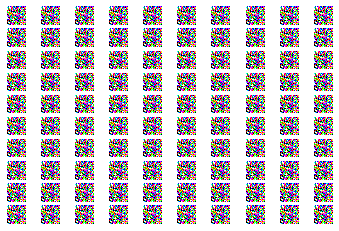

In [45]:
for epoch in range(epochs+1):
  for batch in range(int(batch_count)):
    #generating fake images from noise from generator using first half batch
    noise=np.random.normal(0,1, (half_batch,latent_dimension))
    fake_images=g.predict(noise)
    fake_images=np.reshape(fake_images,(fake_images.shape[0],fake_images.shape[1]*fake_images.shape[2]*fake_images.shape[3]))
    fake_labels=np.zeros((half_batch,1))
    
    #using real images from dataset using other half batch
    idx=np.random.randint(0,X_train.shape[0],half_batch)
    real_images=X_train[idx]    
    real_images=np.reshape(real_images,(-1,32*32*3))
    real_labels=np.ones((half_batch,1))

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real=d.train_on_batch(real_images,real_labels) 
    d_loss_fake=d.train_on_batch(fake_images,fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Plot the progress
    print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))
    if batch % 50 == 0:
        plot_generated_images(epoch, g)

Resources Referred

*   [Best Gan to refer](https://hub.packtpub.com/generative-adversarial-networks-using-keras/)

*   [CIFAR-10 Dataset](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

*   [GAN_Medium](https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3)